# Quantitative Comparison of Embedding on Downstream Tasks
#### EsterHlav 2019

# 1. Load the embeddings

### Import the embeddings

In [1]:
from flair.data import Sentence
from flair.embeddings import (
    StackedEmbeddings,
    FlairEmbeddings,
    WordEmbeddings,
    ELMoEmbeddings,
    BertEmbeddings, 
    TransformerXLEmbeddings,
    XLNetEmbeddings,
    XLMEmbeddings,
    RoBERTaEmbeddings
)

### Load the embeddings

In [ ]:
WORD2VEC = WordEmbeddings('en')
GLOVE    = WordEmbeddings('glove')
ELMO     = ELMoEmbeddings()
FLAIR    = StackedEmbeddings([FlairEmbeddings('news-forward'), FlairEmbeddings('news-backward')])
BERT     = BertEmbeddings()
T_XL     = TransformerXLEmbeddings()
XL_NET   = XLNetEmbeddings()
XLM      = XLMEmbeddings()
ROBERTA  = RoBERTaEmbeddings()

EMBEDDINGS = [WORD2VEC, GLOVE, ELMO, FLAIR, BERT, T_XL, XL_NET, XLM, ROBERTA]
EMBEDDINGS_NAMES = ['WORD2VEC', 'GLOVE', 'ELMO', 'FLAIR', 'BERT', 'T_XL', 'XL_NET', 'XLM', 'ROBERTA']

In [0]:
# create sentence.
s = 'The grass is green .'

# now check out the embedded tokens.
for emb, name in zip(EMBEDDINGS, EMBEDDINGS_NAMES):
    sentence = Sentence(s)
    emb.embed(sentence)
    print ("{0: <15} {1}".format(name+' shape:', sentence[0].embedding.shape))

WORD2VEC shape: torch.Size([300])
GLOVE shape:    torch.Size([100])
ELMO shape:     torch.Size([3072])
FLAIR shape:    torch.Size([4096])
BERT shape:     torch.Size([3072])
T_XL shape:     torch.Size([3072])
XL_NET shape:   torch.Size([2048])
XLM shape:      torch.Size([4096])
ROBERTA shape:  torch.Size([1024])


# 2. Run SentEval experiment

The aggregation of embeddings at the sentence level is done by average pooling.

In [3]:
from __future__ import absolute_import, division, unicode_literals

import sys
import io
import numpy as np
import logging
from flair.data import Sentence

# Set PATHs
PATH_TO_SENTEVAL = './'
PATH_TO_DATA = './data'

# import SentEval
sys.path.insert(0, PATH_TO_SENTEVAL)
sys.path.insert(0, PATH_TO_SENTEVAL+'senteval/tools/')
import senteval

# SentEval prepare and batcher
def prepare(params, samples):
    return

def sentence_emb(sent, type_sent='avg'):
    if type_sent == 'avg':
        sentvec = [tok.embedding.cpu().numpy() for tok in sent]
        return np.mean(sentvec, 0)

# integration of Flair in the batcher
def batcher(params, batch):
    batch = [sent if sent != [] else ['.'] for sent in batch]
    embeddings = []

    for sent in batch:
        sentvec = []
        # create sentence, embed it and recuperate the tokens
        sentence = Sentence(' '.join(sent))
        params['embeddings'].embed(sentence)
        embeddings.append(sentence_emb(sentence))

    embeddings = np.vstack(embeddings)
    return embeddings

# Set up logger
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

The search space for the Sequential Bayesian Optimization can be changed at `senteval/tools/hyperopt_changes.py`.

In [ ]:
# Set params for SentEval
params_senteval = {'task_path': PATH_TO_DATA}
params_senteval['batch_size'] = 256
params_senteval['seed'] = 1
# control the number of max iterations in Bayesian Optimization (most likely will always reach max anyway with NN)
params_senteval['iter_bayes'] = 500
params_senteval['cudaEfficient'] = True

# define embeddings
embs = {name: emb for emb, name in zip(EMBEDDINGS, EMBEDDINGS_NAMES)}

results_embs = {}

for i, emb_name in enumerate(embs.keys()):
    print ("###"*20)
    print ('Training step {} on embedding {}'.format(i+1, emb_name))
    print ("###"*20)
    
    params_senteval['embeddings'] = embs[emb_name]

    se = senteval.engine.SE(params_senteval, batcher, prepare)

    transfer_tasks = ['CR', 'TREC', 'SICKEntailment', 'MRPC', 'SUBJ', 'MPQA', 'SST5', 'SST2'] # can be long to run on SST2

    results = se.eval(transfer_tasks)
    print ("Results for embedding '{}'".format(emb_name))
    print(results)
    results_embs[emb_name] = results
    
print(results_embs)

### Save results

In [0]:
import pickle
pickle.dump(results_embs, open('results3.p', "wb"))

In [0]:
# results obtained for the Transformer based approach.
# -> the runs had a tendency to stop in Colab, hence I had to manually put the results together.

resultXLM = {
              'CR': 
               {'devacc': 80.91872791519434, 
                'acc': 80.25, 
                'ndev': 566, 
                'ntest': 566, 
                'best_params': {
                    'l2reg': 0.02597806371356546, 
                    'lr': 0.009743976977556731, 
                    'max_epoch': 40.0, 
                    'type': {
                        'act_fn': 'elu', 
                        'dropout': 0.4678308608620179, 
                        'nb_hid': 100.0, 
                        'nb_layers': 1, 
                        'type': 'MLP'}}, 
                'time_preprocess': 2332.363485813141, 
                'time_train': 1952.436451435089
               }, 
             'TREC': 
               {'devacc': 81.7625458996328, 
                'acc': 88.2, 
                'ndev': 5452, 
                'ntest': 500, 
                'best_params': {
                    'l2reg': 0.0019412663220885911, 
                    'lr': 0.08316810449125858, 
                    'max_epoch': 80.0, 
                    'type': {
                        'type': 'LogisticRegression'}}, 
                'time_preprocess': 1832.0795273780823, 
                'time_train': 1760.604731798172
               }, 
             'SICKEntailment': {
                 'devacc': 56.39999999999999, 
                 'acc': 56.69, 
                 'ndev': 500, 
                 'ntest': 4927, 
                 'best_params': {
                     'l2reg': 0.02990388742181088, 
                     'lr': 0.2726956453086043, 
                     'max_epoch': 60.0, 
                     'type': {
                         'type': 'LogisticRegression'}}, 
                 'time_preprocess': 676.1056523323059, 
                 'time_train': 4916.32032418251
              }, 
             'MRPC': {
                 'devacc': 73.48608837970541, 
                 'acc': 73.39, 
                 'f1': 80.75, 
                 'ndev': 4076, 
                 'ntest': 1725, 
                 'best_params': {
                     'l2reg': 0.0015201222110683926, 
                     'lr': 0.005378760377195714, 
                     'max_epoch': 50.0, 
                     'type': {
                         'type': 'LogisticRegression'}}, 
                 'time_preprocess': 7009.651634931564, 
                 'time_train': 1595.0631515979767
              }, 
             'SUBJ': {
                 'devacc': 92.46666666666667, 
                 'acc': 91.27, 
                 'ndev': 1500, 
                 'ntest': 1500, 
                 'best_params': {
                     'l2reg': 0.0014230184116853196, 
                     'lr': 0.02249429771543195, 
                     'max_epoch': 100.0, 
                     'type': {'type': 'LogisticRegression'}}, 
                 'time_preprocess': 6007.072983264923, 
                 'time_train': 4842.456591844559
              }, 
             'MPQA': {
                 'devacc': 88.12067881835324, 
                 'acc': 87.62, 
                 'ndev': 1590, 
                 'ntest': 1590, 
                 'best_params': {
                     'l2reg': 0.0013881733854157808, 
                     'lr': 0.07858794180405551, 
                     'max_epoch': 70.0, 
                     'type': {
                         'act_fn': 'sigmoid', 
                         'dropout': 0.4904407129535707, 
                         'nb_hid': 40.0, 
                         'nb_layers': 2, 
                         'type': 'MLP'}}, 
                 'time_preprocess': 836.7405827045441, 
                 'time_train': 4641.529408931732}
              }

resultT_XL = {
              'CR': 
               {'devacc': 81.2720848056537, 
                'acc': 79.01, 
                'ndev': 566, 
                'ntest': 566, 
                'best_params': {
                    'l2reg': 0.005082276720899405, 
                    'lr': 0.0017915553553086317, 
                    'max_epoch': 40.0, 
                    'type': {
                        'act_fn': 'elu', 
                        'dropout': 0.20448326542867828, 
                        'nb_hid': 140.0, 
                        'nb_layers': 1, 
                        'type': 'MLP'}}, 
                'time_preprocess': 8664.0, 
                'time_train': 5903.0
               }, 
             'TREC': 
               {'devacc': 82.25214198286413, 
                'acc': 87.8, 
                'ndev': 5452, 
                'ntest': 500, 
                'best_params': {
                    'l2reg': 0.0012041982870573341, 
                    'lr': 0.41994337767219886, 
                    'max_epoch': 60.0, 
                    'type': {
                        'act_fn': 'tanh', 
                        'dropout': 0.37995603922086046, 
                        'nb_hid': 20.0, 
                        'nb_layers': 2, 
                        'type': 'MLP'}}, 
                'time_preprocess': 7856.0, 
                'time_train': 2526.0
               }, 
             'SICKEntailment': {
                 'devacc': 56.39999999999999, 
                 'acc': 56.69, 
                 'ndev': 500, 
                 'ntest': 4927, 
                 'best_params': {
                     'l2reg': 0.02990388742181088, 
                     'lr': 0.2726956453086043, 
                     'max_epoch': 60.0, 
                     'type': {
                         'l2reg': 0.7405076632927057, 
                         'lr': 0.31608380188635216, 
                         'max_epoch': 60.0, 
                         'type': {
                             'type': 'LogisticRegression'}}}, 
                 'time_preprocess': 2972.0, 
                 'time_train': 4590.0
              },
            'MRPC': {
                'devacc': 72.17675941080196, 
                'acc': 70.43, 
                'f1': 81.05, 
                'ndev': 4076, 
                'ntest': 1725, 
                'best_params': {
                    'l2reg': 0.0013098593793362744, 
                    'lr': 0.011266293543267697, 
                    'max_epoch': 100.0, 
                    'type': {
                        'act_fn': 'elu', 
                        'dropout': 0.3784386395755555, 
                        'nb_hid': 20.0, 
                        'nb_layers': 2, 
                        'type': 'MLP'}}, 
                'time_preprocess': 1147.9935863018036, 
                'time_train': 8999.091785907745}, 
            'SUBJ': {
                'devacc': 93.53333333333333, 
                'acc': 92.6, 
                'ndev': 1500, 
                'ntest': 1500, 
                'best_params': {
                    'l2reg': 0.002563310559588428, 
                    'lr': 0.5097476078332001, 
                    'max_epoch': 60.0, 
                    'type': {
                        'type': 'LogisticRegression'}}, 
                'time_preprocess': 1099.1465981006622, 
                'time_train': 4661.748245716095}, 
            'MPQA': {
                'devacc': 89.12633563796355, 
                'acc': 90.07, 
                'ndev': 1590, 
                'ntest': 1590, 
                'best_params': {
                    'l2reg': 0.04028795414013317, 
                    'lr': 0.007607222123966612, 
                    'max_epoch': 40.0, 
                    'type': {
                        'act_fn': 'elu', 
                        'dropout': 0.26762786582897247, 
                        'nb_hid': 80.0, 
                        'nb_layers': 2, 
                        'type': 'MLP'}}, 
                'time_preprocess': 889.5948889255524, 
                'time_train': 6647.438008546829}
}

resultRoBERTa = {
                'CR': {
                    'devacc': 90.98939929328623, 
                    'acc': 90.65, 
                    'ndev': 566, 
                    'ntest': 566, 
                    'best_params': {
                        'l2reg': 0.0027951773305897915, 
                        'lr': 0.0010586079298072599, 
                        'max_epoch': 40.0, 
                        'type': {
                            'act_fn': 'sigmoid', 
                            'dropout': 0.28309279005658433, 
                            'nb_hid': 100.0, 
                            'nb_layers': 1, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 94.4595627784729, 
                    'time_train': 1027.734503030777}, 
                'TREC': {
                    'devacc': 85.92411260709915, 
                    'acc': 93.6, 
                    'ndev': 5452, 
                    'ntest': 500, 
                    'best_params': {
                        'l2reg': 0.0022679000879462603, 
                        'lr': 0.12948584340942976, 
                        'max_epoch': 60.0, 
                        'type': {
                            'act_fn': 'elu', 
                            'dropout': 0.2761468001091064, 
                            'nb_hid': 120.0, 
                            'nb_layers': 2, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 218.55551624298096, 
                    'time_train': 5161.173000574112}, 
                'SICKEntailment': {
                    'devacc': 76.8, 
                    'acc': 75.12, 
                    'ndev': 500, 
                    'ntest': 4927, 
                    'best_params': {
                        'l2reg': 0.0021264547047057866, 
                        'lr': 0.006785673191461582, 
                        'max_epoch': 80.0, 
                        'type': {
                            'act_fn': 'tanh', 
                            'dropout': 0.27570561320817627, 
                            'nb_hid': 20.0, 
                            'nb_layers': 2, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 585.6354229450226, 
                    'time_train': 3637.4127628803253}, 
                'MRPC': {
                    'devacc': 72.99509001636662, 
                    'acc': 74.2, 
                    'f1': 82.81, 
                    'ndev': 4076, 
                    'ntest': 1725, 
                    'best_params': {
                        'l2reg': 0.0012756375584857052, 
                        'lr': 0.021606406186347533, 
                        'max_epoch': 70.0, 
                        'type': {
                            'type': 'LogisticRegression'}}, 
                    'time_preprocess': 633.4881143569946, 
                    'time_train': 2353.88361787796}, 
                'SUBJ': {
                    'devacc': 95.6, 
                    'acc': 97.0, 
                    'ndev': 1500, 
                    'ntest': 1500, 
                    'best_params': {
                        'l2reg': 0.0033756760277438387, 
                        'lr': 0.16530154456556945, 
                        'max_epoch': 50.0, 
                        'type': {
                            'act_fn': 'tanh', 
                            'dropout': 0.25964693958343404, 
                            'nb_hid': 140.0, 
                            'nb_layers': 2, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 351.1987268924713, 
                    'time_train': 5201.287821769714}, 
                'MPQA': {
                    'devacc': 89.56631049654305, 
                    'acc': 89.06, 
                    'ndev': 1590, 
                    'ntest': 1590, 
                    'best_params': {
                        'l2reg': 0.0014144467750558324, 
                        'lr': 0.3981984247364064, 
                        'max_epoch': 20.0, 
                        'type': {
                            'act_fn': 'sigmoid', 
                            'dropout': 0.4362587098208442, 
                            'nb_hid': 20.0, 
                            'nb_layers': 2, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 283.32609462738037, 
                    'time_train': 3749.548224925995}
}

resultXL_NET = {
                'CR': {
                    'devacc': 81.62544169611307, 
                    'acc': 82.01, 
                    'ndev': 566, 
                    'ntest': 566, 
                    'best_params': {
                        'l2reg': 0.057380392320098596, 
                        'lr': 0.005456028078904308, 
                        'max_epoch': 90.0, 
                        'type': {
                            'act_fn': 'sigmoid', 
                            'dropout': 0.4320555397173106, 
                            'nb_hid': 40.0, 
                            'nb_layers': 1, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 154.0, 
                    'time_train': 665.0}, 
                'TREC': {
                    'devacc': 84.57772337821298, 
                    'acc': 90.4, 
                    'ndev': 5452, 
                    'ntest': 500, 
                    'best_params': {
                        'l2reg': 0.002688044024777605, 
                        'lr': 0.10915110133653314, 
                        'max_epoch': 70.0, 
                        'type': {'type': 'LogisticRegression'}}, 
                    'time_preprocess': 213.0, 
                    'time_train': 998.0}, 
                'SICKEntailment': {
                    'devacc': 83.2, 
                    'acc': 82.16, 
                    'ndev': 500, 
                    'ntest': 4927, 
                    'best_params': {
                        'l2reg': 0.007573636625886776, 
                        'lr': 0.015475412272266311, 
                        'max_epoch': 60.0, 
                        'type': {
                            'act_fn': 'elu', 
                            'dropout': 0.48757704666849855, 
                            'nb_hid': 20.0, 
                            'nb_layers': 1, 
                            'type': 'MLP'}}, 
                    'time_preprocess': 770.0, 
                    'time_train': 1676.0}, 
                  'MRPC': {
                    'devacc': 71.3847332, 
                    'acc': 70.15, 
                    'f1': 80.06, 
                    'ndev': 4076, 
                    'ntest': 1725, 
                    'best_params': {
                        'l2reg': 0.0031495838535, 
                        'lr': 0.0430298485940, 
                        'max_epoch': 70.0, 
                        'type': {
                            'type': 'LogisticRegression'}}, 
                    'time_preprocess': 689.93746563734, 
                    'time_train': 1054.38374563748}, 
                  'SUBJ': {
                      'devacc': 92.13333333333334, 
                      'acc': 90.8, 
                      'ndev': 1500, 
                      'ntest': 1500, 
                      'best_params': {
                          'l2reg': 0.004545136714936342, 
                          'lr': 0.03255249380690274, 
                          'max_epoch': 100.0, 
                          'type': {
                              'act_fn': 'tanh', 
                              'dropout': 0.2839791973195795, 
                              'nb_hid': 140.0, 
                              'nb_layers': 2, 'type': 'MLP'}}, 
                      'time_preprocess': 412.92195081710815, 
                      'time_train': 2892.278753757477}, 
                  'MPQA': {
                      'devacc': 89.75487115021998, 
                      'acc': 89.0, 
                      'ndev': 1590, 
                      'ntest': 1590, 
                      'best_params': {
                          'l2reg': 0.002176662634308791, 
                          'lr': 0.01860540267339282, 
                          'max_epoch': 60.0, 
                          'type': {
                              'act_fn': 'sigmoid', 
                              'dropout': 0.5271040379341697, 
                              'nb_hid': 20.0, 
                              'nb_layers': 2, 
                              'type': 'MLP'}}, 
                      'time_preprocess': 396.04455065727234, 
                      'time_train': 2110.0699083805084}
}

# 3. Load and print/plot results

If needed, load the results.

In [5]:
import pickle
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result
  
results1 = pickle.load(open('results1.p', "rb"))
results2 = pickle.load(open('results2.p', "rb"))

# joining the results of main 5 embeddings in results1
for k in results1.keys():
    for j in results2[k].keys():
        if j not in list(results1[k].keys()):
            results1[k][j] = results2[k][j]

results = merge_dicts(results1, {'XLM': resultXLM}, {'XL_NET': resultXL_NET}, {'T_XL': resultT_XL}, {'RoBERTa': resultRoBERTa})
print (results.keys())

dict_keys(['word2vec', 'glove', 'elmo', 'bert', 'flair', 'XLM', 'XL_NET', 'T_XL', 'RoBERTa'])


### Print the results.

In [6]:
def tft(t):
    #return t
    if t<60:
        return str(round(t, 1))+'s'
    elif t<60*60 and t>=60:
        return str(int(t/60))+'m '+str(int(t%60))+'s'
    elif t>=60*60:
        return str(int(t/(60*60)))+'h '+str(int(t%(60*60)/60))+'m'

for k in results.keys():
    print ("\n<<<<<<<<<<     Embedding {}   >>>>>>>>>>".format(k))
    for l in results[k].keys():
        print ("===  {}  ===".format(l))
        for j in results[k][l].keys():
            if j in ['time_preprocess', 'time_train']:
                print ("{}: {}".format(j, tft(results[k][l][j])))
            else:
                print ("{}: {}".format(j, results[k][l][j]))


<<<<<<<<<<     Embedding word2vec   >>>>>>>>>>
===  CR  ===
devacc: 82.3321554770318
acc: 80.95
ndev: 566
ntest: 566
best_params: {'l2reg': 0.001131730444026091, 'lr': 0.057619377919681664, 'max_epoch': 50.0, 'type': {'act_fn': 'sigmoid', 'dropout': 0.16296603530730489, 'nb_hid': 120.0, 'nb_layers': 1, 'type': 'MLP'}}
time_preprocess: 2.1s
time_train: 10m 46s
===  TREC  ===
devacc: 75.27539779681763
acc: 83.0
ndev: 5452
ntest: 500
best_params: {'l2reg': 0.0012997728271361723, 'lr': 0.11241652736157995, 'max_epoch': 40.0, 'type': {'act_fn': 'elu', 'dropout': 0.36332083454013503, 'nb_hid': 100.0, 'nb_layers': 2, 'type': 'MLP'}}
time_preprocess: 2.0s
time_train: 31m 46s
===  SICKEntailment  ===
devacc: 79.2
acc: 78.49
ndev: 500
ntest: 4927
best_params: {'l2reg': 0.001206519195640514, 'lr': 0.31167131976710516, 'max_epoch': 50.0, 'type': {'act_fn': 'elu', 'dropout': 0.5580976745433995, 'nb_hid': 30.0, 'nb_layers': 3, 'type': 'MLP'}}
time_preprocess: 6.5s
time_train: 24m 48s
===  SST5  ===

### Plot the results.

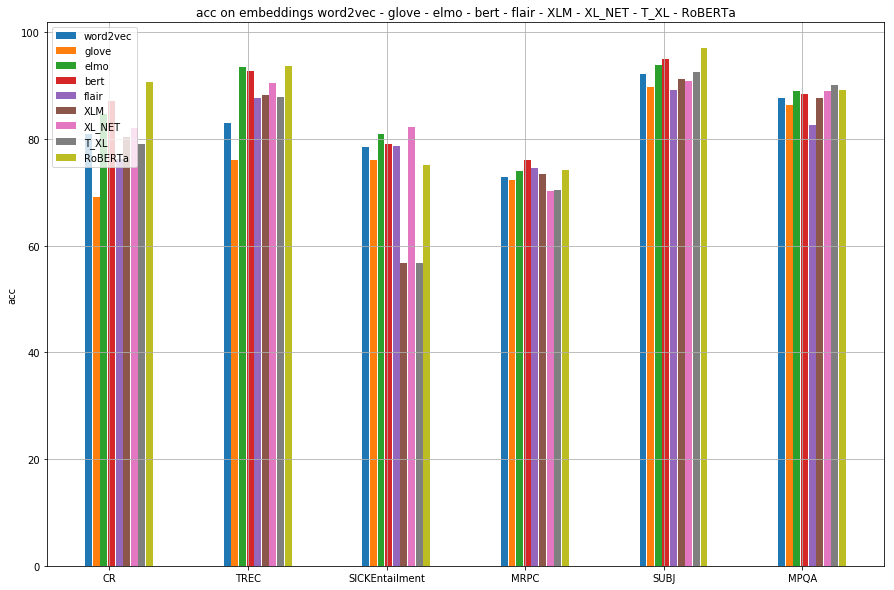

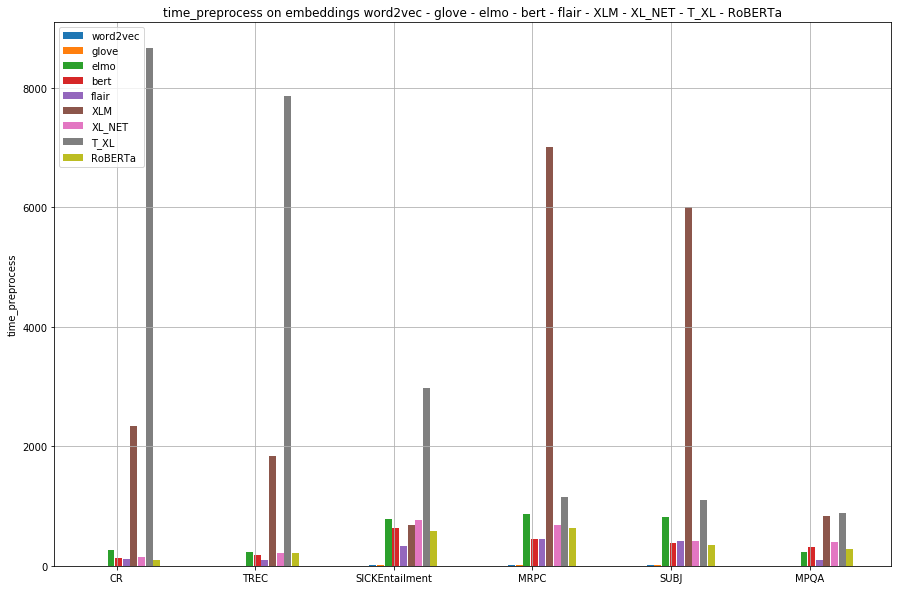

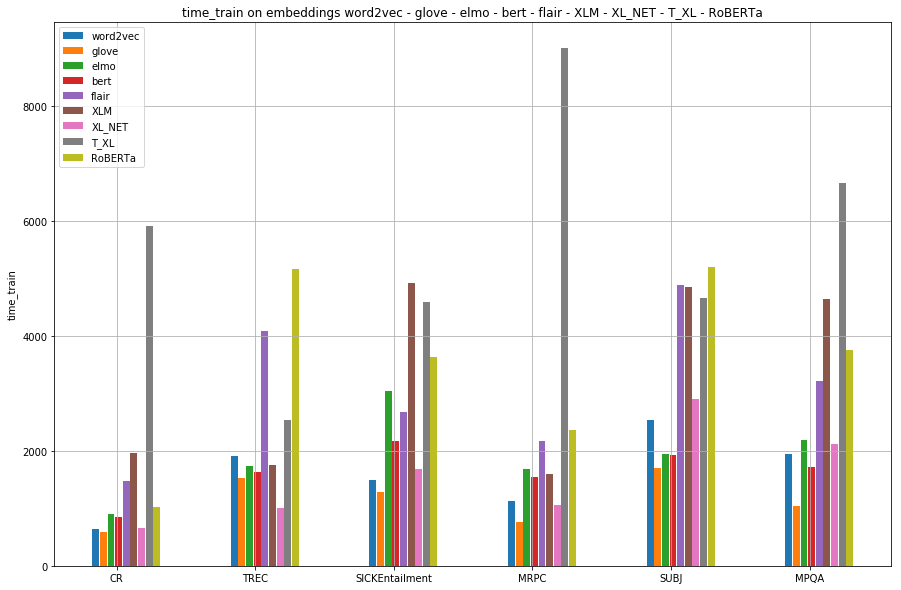

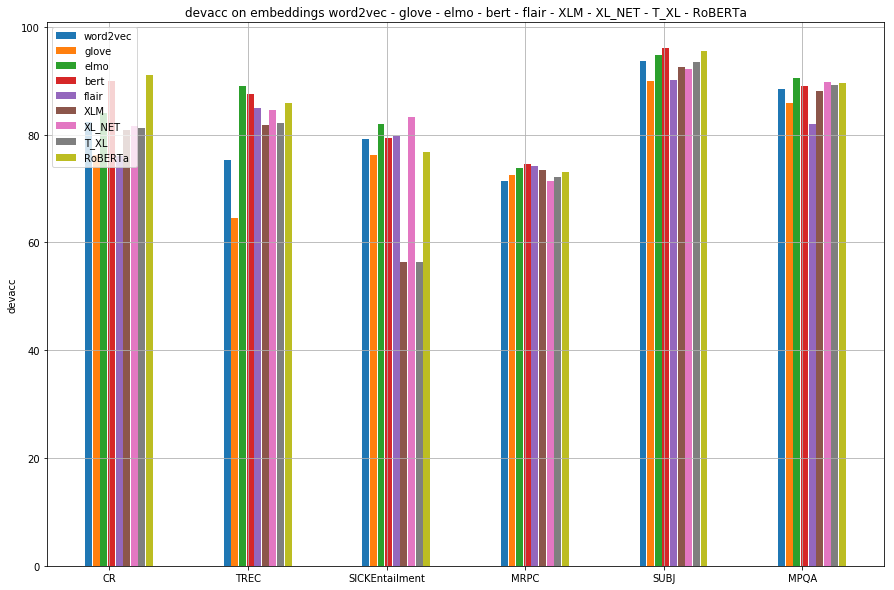

In [7]:
import matplotlib.pyplot as plt

embs = list(results.keys())
tasks = list(results['T_XL'].keys())

for METRIC in  ['acc', 'time_preprocess', 'time_train', 'devacc']:
    res = {}
    # try l2reg or lr
    METRIC2 = None
    for e in embs:
        res[e] = []
        for t in tasks:
            try:
                if METRIC2 is None:
                    res[e].append(results[e][t][METRIC])
                else:
                    res[e].append(results[e][t]['best_params'][METRIC2])
            except KeyError:
                pass

#print (res)        

# Setting the positions and width for the bars
pos = list(range(len(tasks))) 
width = 0.05 

# Plotting the bars
fig, ax = plt.subplots(figsize=(15,10))

for i, e in enumerate(embs):
    plt.bar([p + i*width*1.1 for p in pos], res[e], width, label=e) 

ax.set_ylabel(METRIC)

ax.set_title("{} on embeddings {}".format(METRIC, ' - '.join(embs)))

ax.set_xticks([p + len(tasks)/2 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(tasks)

# # Setting the x-axis and y-axis limits
# plt.xlim(min(pos)-width, max(pos)+width*4)
#plt.ylim([50, 100])

# Adding the legend and showing the plot
plt.legend(embs, loc='upper left')
plt.grid()
plt.show()